# Predicting the associated animal species of viruses.

#### The data in this notebook comes from ZOVER. http://www.mgc.ac.cn/cgi-bin/ZOVER/main.cgi
#### This project uses the DNA and protein sequences of viruses and classifies them as being associated with either bats, rodents, mosquitos, or ticks.

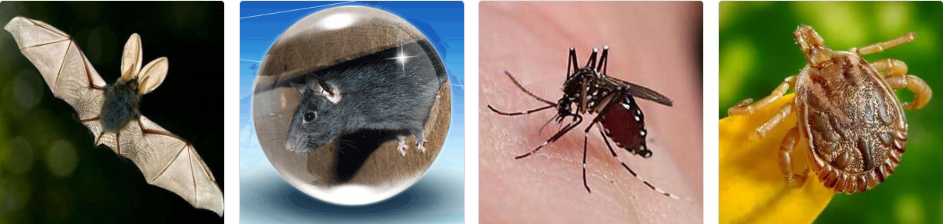

### 1. Importing packages

In [1]:
# Standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Models and model metrics
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Random combinations
from itertools import product, combinations
import random

# Neural network objects
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Biopython package
#from Bio import SeqIO

# Filter out warnings
import warnings
warnings.filterwarnings('ignore')

from functions import *

In [2]:
#SeqIO.parse(open(filepath),'fasta')

### 2. Reading in Data

In [3]:
files=os.listdir('text_data')

In [4]:
v_id_pattern='\[.+'
name_pattern='[|gb|]*.+'
dna_sequences={}
host_species={}
protein_sequences={}
name_v_ids={}

for file in files:
    filepath=f'text_data\{file}'
    if 'DNA' in file:
        with open(filepath, "r") as f:
            for i in (f.read().split('>g'))[1:]:
                genome=i.split(')]')[1].strip('\n').replace("\n", '')
                name=re.findall(name_pattern, i.split(']')[0])[0].strip("[]'")
                v_id=re.findall(v_id_pattern, i.split(']')[0])[0].strip("[]'")
                dna_sequences[name]=genome
                if 'Bat' in file:
                    host_species[name]='Bat'
                elif 'Rodent' in file:
                    host_species[name]='Rodent'
                elif 'Mosquito' in file:
                    host_species[name]='Mosquito'
                elif 'Tick' in file:
                    host_species[name]='Tick'
                name_v_ids[name]=v_id
    elif 'Protein' in file:
        with open(filepath, "r") as f:
            for i in (f.read().split('>g'))[1:]:
                genome=i.split(')]')[1].strip('\n').replace("\n", '')
                name=re.findall(name_pattern, i.split(']')[0])[0].strip("[]'")
                v_id=re.findall(v_id_pattern, i.split(']')[0])[0].strip("[]'")
                if v_id in protein_sequences.keys():
                    protein_sequences[v_id].append(genome)
                else:
                    protein_sequences[v_id]=[genome]
                name_v_ids[name]=v_id


### 3. Cleaning and Assembling Data

def duplicate_protein_remover(protein_list):
    blank_list=[]
    for p in protein_list:
        if p not in blank_list:
            blank_list.append(p)
    return blank_list

In [5]:
proteins=pd.DataFrame(zip(protein_sequences.keys(), protein_sequences.values()), columns=['v_id', 'Protein_Sequence'])
proteins['Protein_Sequence']=proteins['Protein_Sequence'].apply(duplicate_protein_remover)

In [6]:
viruses=pd.DataFrame(zip(dna_sequences.keys(), dna_sequences.values()), columns=['Name', 'DNA_Sequence'])
viruses['DNA_length']=viruses.DNA_Sequence.str.len()
viruses.sort_values(by='DNA_length', ascending=False, inplace=True)
viruses.drop_duplicates(['DNA_Sequence'], inplace=True, keep='first', ignore_index=True)

assert(viruses.isna().sum().values.sum()==0)

viruses=viruses.merge(pd.DataFrame(zip(host_species.keys(), host_species.values()), columns=['Name', 'Host_Species']), how='left', left_on='Name', right_on='Name')
v_ids=pd.DataFrame(zip(name_v_ids.keys(), name_v_ids.values()), columns=['Name', 'v_id'])
viruses=viruses.merge(v_ids, how='left', left_on='Name', right_on='Name')

viruses=viruses.merge(proteins, how='left', left_on='v_id', right_on='v_id')
viruses['Protein_Sequence'].fillna('0', inplace=True)

assert(viruses['Protein_Sequence'].isna().sum()==0)

### 4. Exploring the Data

In [7]:
viruses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50462 entries, 0 to 50461
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              50462 non-null  object
 1   DNA_Sequence      50462 non-null  object
 2   DNA_length        50462 non-null  int64 
 3   Host_Species      50462 non-null  object
 4   v_id              50462 non-null  object
 5   Protein_Sequence  50462 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


In [8]:
viruses.head()

,Name,DNA_Sequence,DNA_length,Host_Species,v_id,Protein_Sequence
0,i|0|gb|MK035747| Cowpox virus strain CPXV/Rat ...,GACTCCATCAGAAAGAGGTTTAATATTTTTGTGAGACCATCGAAGA...,65535,Rodent,CPXV/Rat Marl (RVI07737),[MKSVLYSYILFLSCIIINGRDVAPYAPSNGKCKDNEYNRHNLCCL...
1,i|0|gb|MF385016| Eptesicus fuscus gammaherpesv...,GGGTCGCGGCCCCGCCCCGAGGTATCCGCATCCCCCCCCCCCCCCC...,65535,Bat,Ef_gammaherpesvirus (BVI07323),[MGYAGEGTGARPPARGPQSGRRDLLALRTGHMHTMRWMFGCDVDA...
2,i|6625567|gb|AF105037| Murid herpesvirus 4 com...,GCGCGCCCTGGAGATCCGGGGCTGATGCTGGGTTCAGGAGTTCAGG...,65535,Rodent,g2.4 (WUMS)(MHV-68) (RVI03196),[MQLATLCLLSCILGQSIAHWPSVVNIETYPFPEDDTKEDMRDYLF...
3,i|0|gb|MT903347| Monkeypox virus isolate MPXV-...,GTGTCTAGAAAAAAATGTGTGACCCACGACCGTAGGAAACTCTAGA...,65535,Rodent,MPXV-USA2003_099_Dormouse (RVI09551),[MKQYIVLACMCLVAAAMPTSLQQSSSSCTEEENKHHMGIDVIIKV...
4,i|0|gb|OP429124| Mastomys natalensis cytomegal...,TCCCCCCCTGCCCTGAGTGCGCGAGTTGCCCCGGGGGGGTGTTTTC...,65535,Rodent,M.natalensis-wt/MLI/2017/19A (RVI13441),[MPAGDEAARSGWRWLDGTPFDADTYRGLPPSPHLLAIAKDCGSRY...


In [9]:
viruses['Host_Species'].value_counts()

Bat         15268
Rodent      13909
Mosquito    12816
Tick         8469
Name: Host_Species, dtype: int64

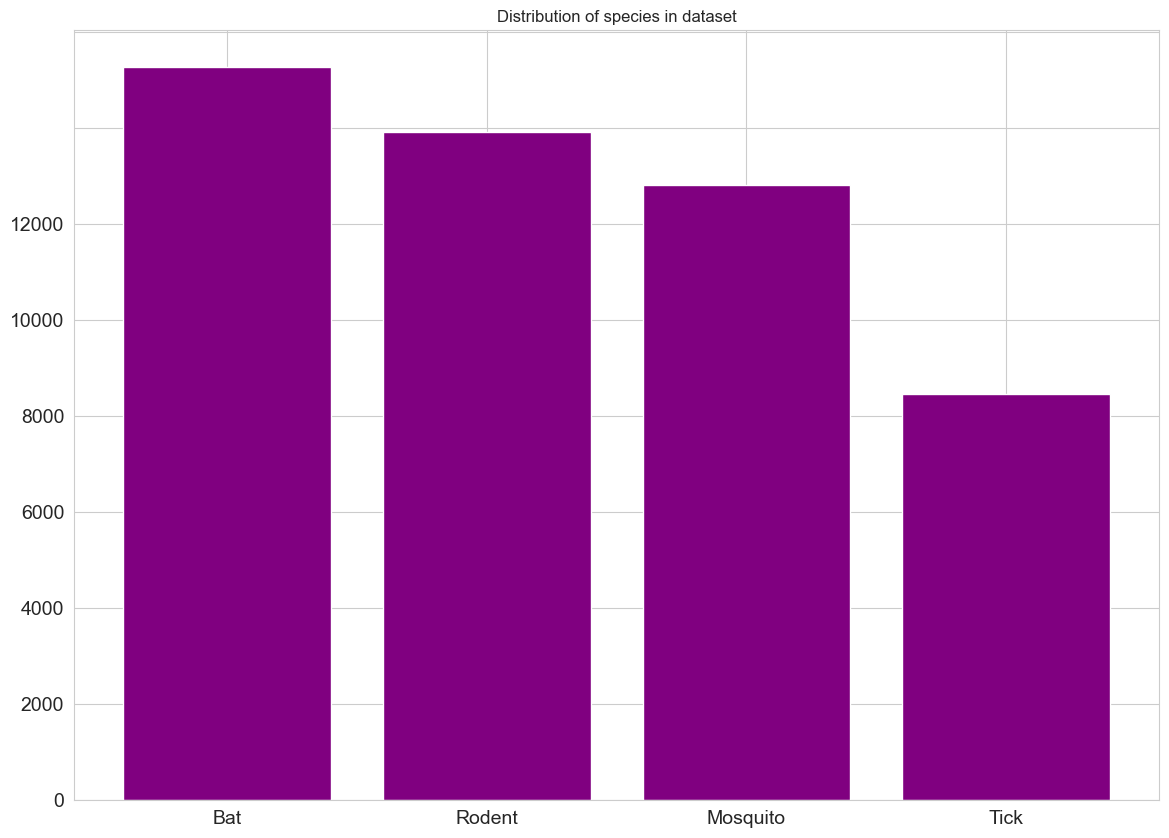

In [10]:
sns.set_style("whitegrid")
fig, ax=plt.subplots(figsize=(14, 10))
ax.bar(viruses['Host_Species'].value_counts().index, viruses['Host_Species'].value_counts().values, color='purple')
ax.set_xticklabels(viruses['Host_Species'].value_counts().index, size=14)
ax.set_yticklabels(np.arange(0, 14000, 2000), size=14)
ax.set_title('Distribution of species in dataset');

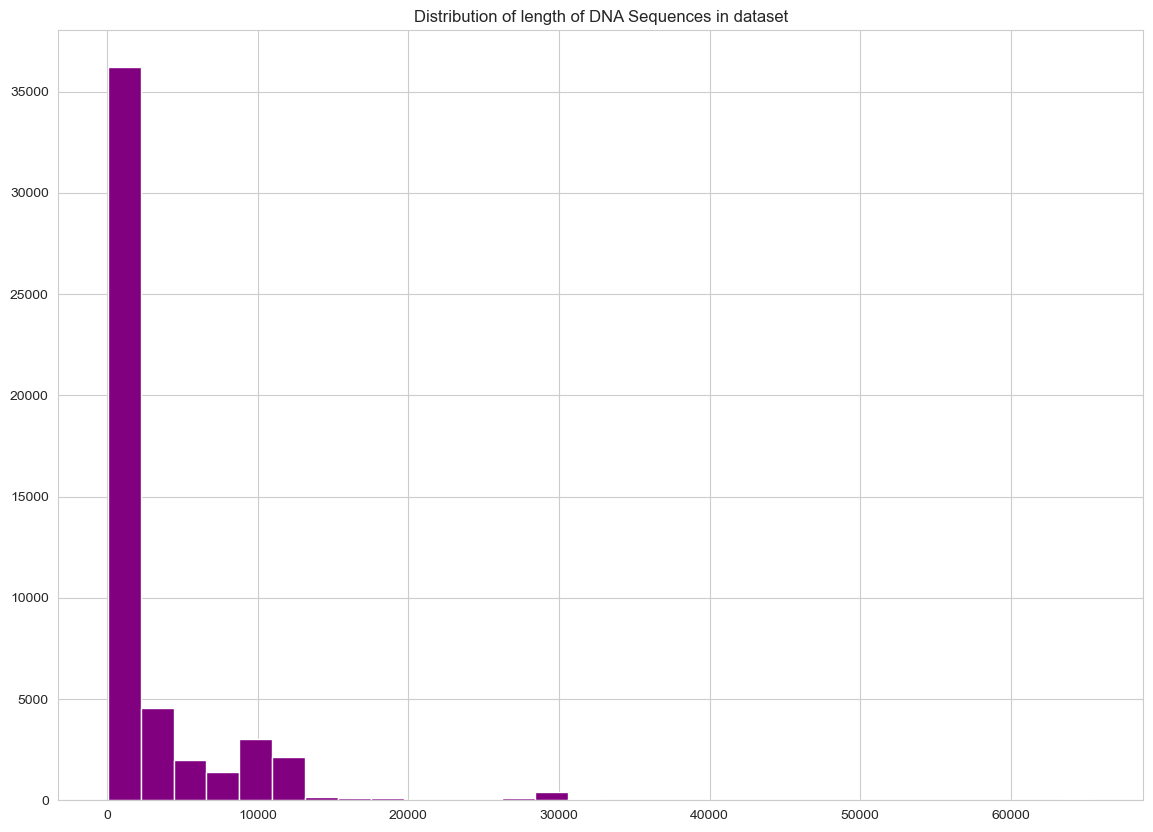

In [11]:
fig, ax=plt.subplots(figsize=(14, 10))
ax.hist(viruses['DNA_length'], bins=30, color='purple')
ax.set_title('Distribution of length of DNA Sequences in dataset');

### 5. Feature Engineering

In [12]:
protein_letters=['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', 'B', 'J', 'Z']

In [13]:
viruses['letter_dict']=viruses['Protein_Sequence'].apply(single_protein_averager)
for letter in protein_letters:
    viruses[letter]=viruses['letter_dict'].apply(lambda x: x[letter])
viruses.drop('letter_dict', axis=1, inplace=True)

In [14]:
dna_letters=['A', 'C', 'G', 'T']

eight_combos=[]
for c in product(dna_letters, repeat=8):
    s=''
    for k in c:
        s+=k
    eight_combos.append(s)

seven_combos=[]
for c in product(dna_letters, repeat=7):
    s=''
    for k in c:
        s+=k
    seven_combos.append(s)

six_combos=[]
for c in product(dna_letters, repeat=6):
    s=''
    for k in c:
        s+=k
    six_combos.append(s)

five_combos=[]
for c in product(dna_letters, repeat=5):
    s=''
    for k in c:
        s+=k
    five_combos.append(s)    


three_combos=[]
for letter in product(protein_letters, repeat=3):
    s=''
    for l in letter:
        s+=l
    three_combos.append(s)
three_combos


for eight_combo in random.sample(eight_combos, 1200):
    viruses[eight_combo]=viruses['DNA_Sequence'].apply(lambda x: 1 if eight_combo in x else 0)
for seven_combo in random.sample(seven_combos, 2000):
    viruses[seven_combo]=viruses['DNA_Sequence'].apply(lambda x: 1 if seven_combo in x else 0)
for six_combo in random.sample(six_combos, 800):
    viruses[six_combo]=viruses['DNA_Sequence'].apply(lambda x: 1 if six_combo in x else 0)
for five_combo in random.sample(five_combos, 500):
    viruses[five_combo]=viruses['DNA_Sequence'].apply(lambda x: 1 if five_combo in x else 0)
for three_combo in random.sample(three_combos, 1000):
    viruses[three_combo]=viruses['Protein_Sequence'].apply(lambda x: 1 if three_combo in str(x) else 0)

viruses
#2000, 800
#1200, 2000, 800, 500

,Name,DNA_Sequence,DNA_length,Host_Species,v_id,Protein_Sequence,A,R,N,D,...,GRE,LPX,RIX,YPZ,WMA,ERA,GIN,QJR,RFX,FCX
0,i|0|gb|MK035747| Cowpox virus strain CPXV/Rat ...,GACTCCATCAGAAAGAGGTTTAATATTTTTGTGAGACCATCGAAGA...,65535,Rodent,CPXV/Rat Marl (RVI07737),[MKSVLYSYILFLSCIIINGRDVAPYAPSNGKCKDNEYNRHNLCCL...,0.038465,0.042882,0.069841,0.067484,...,1,0,0,0,0,1,1,0,0,0
1,i|0|gb|MF385016| Eptesicus fuscus gammaherpesv...,GGGTCGCGGCCCCGCCCCGAGGTATCCGCATCCCCCCCCCCCCCCC...,65535,Bat,Ef_gammaherpesvirus (BVI07323),[MGYAGEGTGARPPARGPQSGRRDLLALRTGHMHTMRWMFGCDVDA...,0.107119,0.076544,0.029361,0.050918,...,1,0,0,0,0,1,1,0,0,0
2,i|6625567|gb|AF105037| Murid herpesvirus 4 com...,GCGCGCCCTGGAGATCCGGGGCTGATGCTGGGTTCAGGAGTTCAGG...,65535,Rodent,g2.4 (WUMS)(MHV-68) (RVI03196),[MQLATLCLLSCILGQSIAHWPSVVNIETYPFPEDDTKEDMRDYLF...,0.061823,0.047756,0.041367,0.046064,...,1,0,0,0,0,1,1,0,0,0
3,i|0|gb|MT903347| Monkeypox virus isolate MPXV-...,GTGTCTAGAAAAAAATGTGTGACCCACGACCGTAGGAAACTCTAGA...,65535,Rodent,MPXV-USA2003_099_Dormouse (RVI09551),[MKQYIVLACMCLVAAAMPTSLQQSSSSCTEEENKHHMGIDVIIKV...,0.037967,0.042337,0.068183,0.067978,...,1,0,0,0,0,1,1,0,0,0
4,i|0|gb|OP429124| Mastomys natalensis cytomegal...,TCCCCCCCTGCCCTGAGTGCGCGAGTTGCCCCGGGGGGGTGTTTTC...,65535,Rodent,M.natalensis-wt/MLI/2017/19A (RVI13441),[MPAGDEAARSGWRWLDGTPFDADTYRGLPPSPHLLAIAKDCGSRY...,0.068659,0.073521,0.037925,0.062221,...,1,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50457,i|0|gb|MZ218070| MAG: Rotavirus H isolate RVH/...,AACTTGCACAGCTCTCACTAAGAATACAAAAAATGGAATCAGAAAC...,58,Bat,RVH/18802-1/M.das/DK/2016 (BVI12858),"[VYNNPKVAIVTLQDSKEEFISFEKEQKAPN, VLESKVSISEKLR...",0.053531,0.046334,0.053981,0.048133,...,0,0,0,0,0,0,0,0,0,0
50458,i|2147483647|gb|ON815484| West Nile virus isol...,AAAGAACTAGGAACCCTGACCAGCGCCATCAACCGGCGGAGCTCAA...,53,Mosquito,UPM126-Selangor (MVI13607),[KELGTLTSAINRRSSKQ],0.058824,0.117647,0.058824,0.000000,...,0,0,0,0,0,0,0,0,0,0
50459,i|2147483647|gb|ON815482| West Nile virus isol...,AAAGAACTAGGAACCCTGACCAGCGCCATCAACCGGCGGAGCTCAA...,52,Mosquito,UPM112-Selangor (MVI13605),[KELGTLTSAINRRSSKQ],0.058824,0.117647,0.058824,0.000000,...,0,0,0,0,0,0,0,0,0,0
50460,i|158302675|gb|AB300620| Dengue virus type 4 g...,AGGGAAAGCCAACCTTGGATTTGAATGATCAAGACAACAGCCAAGG...,51,Mosquito,Th-mos-A1 (MVI04803),[GKPTLDLNDQDNSQGS],0.000000,0.000000,0.125000,0.187500,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#viruses.corr().abs().unstack().sort_values(ascending=False)[:10]

### 6. Preprocessing

In [16]:
label_encoder=LabelEncoder()
viruses['Host_Species_Encoded']=label_encoder.fit_transform(viruses['Host_Species'])

X=viruses.drop(['Name', 'DNA_Sequence', 'DNA_length', 'Host_Species', 'v_id', 'Protein_Sequence', 'Host_Species_Encoded'], axis=1)
y=viruses['Host_Species_Encoded']

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_t, X_val, y_t, y_val=train_test_split(X_train, y_train, random_state=42)

assert(len(X_t)==len(y_t))
assert(len(X_val)==len(y_val))
assert(len(X_test)==len(y_test))

In [17]:
scaler=StandardScaler()
X_t_scaled=scaler.fit_transform(X_t)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

### 7. Modeling

In the modeling portion I test out a logistic regression model with scaled data, and an XGboost model with unscaled data.

In [18]:
majority_class_percent=viruses['Host_Species'].value_counts().sort_values(ascending=False)[0]/len(viruses['Host_Species'])

xgboost=xgb.XGBClassifier(max_depth=15, reg_lambda=3, min_child_weight=2)
xgboost.fit(X_t, y_t)

print(accuracy_score(y_val, xgboost.predict(X_val)))
print(f'The xgboost model has a {round((accuracy_score(y_val, xgboost.predict(X_val))-majority_class_percent)/majority_class_percent, 2)*100}% increase in accuracy score compared to just guessing the majority class.')

0.9492707672796449
The xgboost model has a 214.0% increase in accuracy score compared to just guessing the majority class.


In [19]:
#rmse=round(np.sqrt(-cross_val_score(xgboost, X_t, y_t, scoring='neg_mean_squared_error')).mean(),3)
#rmse
xgboost_2=xgb.XGBClassifier(max_depth=10, reg_lambda=3, min_child_weight=2)
xgboost_2.fit(X_t, y_t)
print(accuracy_score(y_val, xgboost_2.predict(X_val)))

xgboost_3=xgb.XGBClassifier(max_depth=11, reg_lambda=3, min_child_weight=2)
xgboost_3.fit(X_t, y_t)
print(accuracy_score(y_val, xgboost_3.predict(X_val)))

xgboost_4=xgb.XGBClassifier(max_depth=12)
xgboost_4.fit(X_t, y_t)
print(accuracy_score(y_val, xgboost_4.predict(X_val)))

xgboost_5=xgb.XGBClassifier(max_depth=13)
xgboost_5.fit(X_t, y_t)
print(accuracy_score(y_val, xgboost_5.predict(X_val)))

0.9517015430141619
0.9506446839991545
0.9495878249841471
0.950856055802156


In [20]:
xgboost_6=xgb.XGBClassifier(max_depth=20)
xgboost_6.fit(X_t, y_t)
print(accuracy_score(y_val, xgboost_6.predict(X_val)))

0.9509617417036568


In [21]:
lb = LabelBinarizer()
y_preds=xgboost.predict(X_test)
y_preds_binarized=lb.fit_transform(y_preds).flatten()
y_test_binarized=lb.transform(y_test).flatten()
roc_auc=round(roc_auc_score(y_test_binarized, y_preds_binarized), 3)

In [22]:
#print(f'Root Mean Squared Error for model is {rmse}')
print(f'ROC-AUC score for single XGBoost model is {roc_auc}')

ROC-AUC score for single XGBoost model is 0.969


### 8. Neural Network

In [23]:
#params={'max_depth': [12, 15, 20]}
#gsv=GridSearchCV(xgboost, param_grid=params)
#gsv.fit(X_t, y_t)
#gsv.best_params_

In [24]:
sequential_model=Sequential()

sequential_model.add(Dense(600, activation='relu', kernel_regularizer=l2(1e-150000000), input_shape=(X_t_scaled.shape[1],)))
sequential_model.add(BatchNormalization())
sequential_model.add(Dropout(0.45))

sequential_model.add(Dense(20, activation='relu', kernel_regularizer=l2(1e-2000))) #arbitrarily chosen size and activation function
sequential_model.add(BatchNormalization())
sequential_model.add(Dropout(0.2))

sequential_model.add(Dense(1100, activation='relu', kernel_regularizer=l2(1e-2000))) #arbitrarily chosen size and activation function
sequential_model.add(BatchNormalization())
sequential_model.add(Dropout(0.35))

sequential_model.add(Dense(100, activation='relu', kernel_regularizer=l2(1e-2000))) #arbitrarily chosen size and activation function
sequential_model.add(BatchNormalization())
sequential_model.add(Dropout(0.25))

sequential_model.add(Dense(8, activation='relu', kernel_regularizer=l2(1e-2000))) #arbitrarily chosen size and activation function
sequential_model.add(BatchNormalization())
sequential_model.add(Dropout(0.1))

sequential_model.add(Flatten()) #ensure shape of label data is correct
sequential_model.add(Dense(4, activation='softmax')) #final layer has 4 nodes because there are 4 classes we are predicting from

sequential_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

sequential_model.fit(X_t_scaled, to_categorical(y_t, num_classes=4), epochs=30, batch_size=300, verbose=0)
val_preds=np.argmax(sequential_model.predict(X_val_scaled), axis=1)

print(f'Accuracy score is {accuracy_score(val_preds, y_val)}')

296/296 [==============================] - 1s 3ms/step
Accuracy score is 0.9348974846755442
RMSE is 0.438334311830987


In [25]:
sequential_model_2=Sequential()

sequential_model_2.add(Dense(250, activation='relu', kernel_regularizer=l2(1e-400), input_shape=(X_t_scaled.shape[1],)))
sequential_model_2.add(BatchNormalization())
sequential_model_2.add(Dropout(0.3))

sequential_model_2.add(Dense(500, activation='relu', kernel_regularizer=l2(1e-60))) #arbitrarily chosen size and activation function
sequential_model_2.add(BatchNormalization())
sequential_model_2.add(Dropout(0.25))

sequential_model_2.add(Flatten()) #ensure shape of label data is correct
sequential_model_2.add(Dense(4, activation='softmax')) #final layer has 4 nodes because there are 4 classes we are predicting from

sequential_model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

sequential_model_2.fit(X_t_scaled, to_categorical(y_t, num_classes=4), epochs=10, batch_size=150, verbose=0)
val_preds=np.argmax(sequential_model_2.predict(X_val_scaled), axis=1)

print(f'Accuracy score is {accuracy_score(val_preds, y_val)}')

296/296 [==============================] - 0s 1ms/step
Accuracy score is 0.9300359332065102
RMSE is 0.45373575583531117


In [26]:
sequential_model_3=Sequential()

sequential_model_3.add(Dense(250, activation='relu', kernel_regularizer=l2(1e-100), input_shape=(X_t_scaled.shape[1],)))
sequential_model_3.add(BatchNormalization())
sequential_model_3.add(Dropout(0.3))

sequential_model_3.add(Dense(500, activation='relu', kernel_regularizer=l2(1e-60))) #arbitrarily chosen size and activation function
sequential_model_3.add(BatchNormalization())
sequential_model_3.add(Dropout(0.25))

sequential_model_3.add(Flatten()) #ensure shape of label data is correct
sequential_model_3.add(Dense(4, activation='softmax')) #final layer has 4 nodes because there are 4 classes we are predicting from

sequential_model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

sequential_model_3.fit(X_t_scaled, to_categorical(y_t, num_classes=4), epochs=10, batch_size=150, verbose=0)
val_preds=np.argmax(sequential_model_3.predict(X_val_scaled), axis=1)

print(f'Accuracy score is {accuracy_score(val_preds, y_val)}')

296/296 [==============================] - 0s 1ms/step
Accuracy score is 0.9326780807440287
RMSE is 0.45721626520549696


In [27]:
#from keras.wrappers.scikit_learn import KerasRegressor

#def model_assembler():
#    sequential_model=Sequential()
#    sequential_model.add(Dense(10, activation='relu', input_shape=(X_t_scaled.shape[1],)))
#    sequential_model.add(Dense(100, activation='relu')) #arbitrarily chosen size and activation function
#    sequential_model.add(Dense(100, activation='relu')) #arbitrarily chosen size and activation function
#    sequential_model.add(Flatten()) #ensure shape of label data is correct
#    sequential_model.add(Dense(4, activation='sigmoid')) #final layer has 4 nodes because there are 4 classes we are predicting from
#    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#    return sequential_model

#params={'epochs':[25, 50], 'batch_size': [20, 100, 500]}
#gs=GridSearchCV(estimator=KerasRegressor(model_assembler), param_grid=params, scoring='neg_mean_squared_error')
#gs.fit(X_t_scaled, to_categorical(y_t, num_classes=4))
#print(gs.best_score_, gs.best_params_)

In [28]:
def predictor(validation_data):

    preds_dict={}
    acc_dict={}

    xgboost_preds=pd.DataFrame(xgboost.predict(validation_data), columns=['xg'])
    xgboost_2_preds=pd.DataFrame(xgboost_2.predict(validation_data), columns=['xg_2'])
    xgboost_3_preds=pd.DataFrame(xgboost_3.predict(validation_data), columns=['xg_3'])
    xgboost_4_preds=pd.DataFrame(xgboost_4.predict(validation_data), columns=['xg_4'])
    xgboost_5_preds=pd.DataFrame(xgboost_5.predict(validation_data), columns=['xg_5'])

    seq_preds=pd.DataFrame(np.argmax(sequential_model.predict(scaler.transform(validation_data)), axis=1), columns=['nn'])
    seq_2_preds=pd.DataFrame(np.argmax(sequential_model_2.predict(scaler.transform(validation_data)), axis=1), columns=['nn_2'])
    seq_3_preds=pd.DataFrame(np.argmax(sequential_model_3.predict(scaler.transform(validation_data)), axis=1), columns=['nn_3'])

    models=[xgboost_preds, xgboost_2_preds, xgboost_3_preds, xgboost_4_preds, xgboost_5_preds, seq_preds, seq_2_preds, seq_3_preds]

    for n in range(3, 9):
        possibilities=combinations(models, n)
        for p in possibilities:
            p=list(p)
            preds=pd.concat(p, axis=1)
            predicted_values=[]
            for i in range (preds.T.shape[1]):
                predicted_values.append(preds.T[i].mode()[0])
            acc_dict[str(list(preds.columns))]=accuracy_score(predicted_values, y_val)
            preds_dict[str(list(preds.columns))]=predicted_values

    max_k=''
    max_v=0
    for k,v in acc_dict.items():
        if v>max_v:
            max_v=v
            max_k=k

    lb = LabelBinarizer()
    binarized_preds=lb.fit_transform(preds_dict[max_k]).flatten()
    y_val_binarized=lb.transform(y_val).flatten()      

    print(f'Accuracy score is {max_v}')
    print(f'ROC AUC score is {round(roc_auc_score(y_val_binarized, binarized_preds), 3)}')

    return max_k, max_v

predictor(X_val)

296/296 [==============================] - 0s 1ms/step
Accuracy score is 0.9544493764531812
RMSE is 0.36650618113128774
ROC AUC score is 0.97


("['xg', 'xg_2', 'xg_3', 'xg_5', 'nn_2', 'nn_3']", 0.9544493764531812)